### Importing the libraries

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

### Preparing the Dataset

In [3]:
mask_labels = ['Correct', 'Incorrect']

In [4]:
path = Path('mask_images')

In [5]:
fns = get_image_files(path)
fns

(#1280) [Path('mask_images/Incorrect/0_0_yangqianhua_0051.jpg'),Path('mask_images/Incorrect/0_0_yangqianhua_0053.jpg'),Path('mask_images/Incorrect/0_0_yangqianhua_0103.jpg'),Path('mask_images/Incorrect/0_0_yangqianhua_0108.jpg'),Path('mask_images/Incorrect/0_0_zhanghe_0004.jpg'),Path('mask_images/Incorrect/0_0_zhanghe_0019.jpg'),Path('mask_images/Incorrect/0_0_zhanghe_0026.jpg'),Path('mask_images/Incorrect/0_0_zhanghe_0027.jpg'),Path('mask_images/Incorrect/0_0_zhanghe_0042.jpg'),Path('mask_images/Incorrect/1_0_yangqianhua_0060.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink)

(#0) []

### Creating a Baseline Model

In [23]:
db = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(seed = 42),
            get_y = parent_label,
            item_tfms = Resize(460),
            batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

dls = db.dataloaders(path)

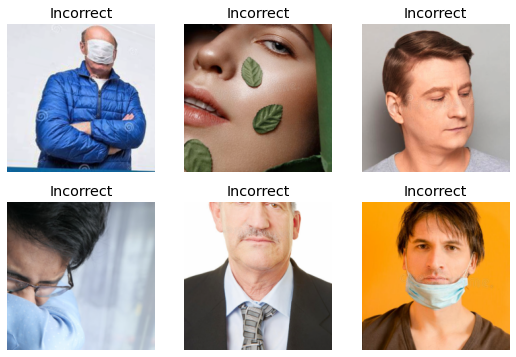

In [24]:
 dls.show_batch(nrows=2, ncols=3)

In [25]:
learn = cnn_learner(dls, resnet18, metrics = accuracy)

In [26]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.901275,0.507026,0.804688,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.541871,0.381990,0.847656,00:07
1,0.434555,0.323058,0.875000,00:07
2,0.342365,0.259890,0.906250,00:07
3,0.259687,0.254328,0.937500,00:07
4,0.202337,0.414565,0.914062,00:07
5,0.160365,0.238182,0.933594,00:07
6,0.128116,0.226516,0.937500,00:07
7,0.106071,0.232577,0.941406,00:07
8,0.092519,0.244340,0.937500,00:07
9,0.078958,0.242662,0.929688,00:07


### Cleaning the data

In [27]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [28]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()

for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

### Testing Augmentation Techniques

#### Normalization

In [72]:
db = DataBlock(
            blocks = (ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
            get_y = parent_label,
            item_tfms = Resize(460),
            batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

dls = db.dataloaders(path, bs = 64)

In [30]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.3121, 0.1762, 0.2968], device='cuda:0'),
 TensorImage([1.3374, 1.2648, 1.2820], device='cuda:0'))

In [31]:
learn = cnn_learner(dls, resnet18, metrics = accuracy)

In [32]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.012771,0.408691,0.820312,00:06
1,0.760531,0.386956,0.843750,00:06
2,0.608679,0.310898,0.867188,00:06
3,0.494411,0.315826,0.878906,00:06
4,0.446470,0.313886,0.878906,00:06


In [38]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = parent_label,
                       item_tfms = Resize(460),
                       batch_tfms = [*aug_transforms(size=size, min_scale = 0.75),
                                    Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

#### Progressive Resizing

In [39]:
dls = get_dls(128,128)
learn = cnn_learner(dls, resnet18, metrics = accuracy).to_fp16()

In [40]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.264848,0.778985,0.816406,00:05
1,1.065531,0.680391,0.855469,00:06
2,0.821469,0.413604,0.867188,00:06
3,0.650218,0.311626,0.898438,00:06
4,0.546583,0.295976,0.898438,00:06


In [73]:
learn.dls = get_dls(64,224)

In [42]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.309418,0.189816,0.917969,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.280905,0.187797,0.917969,00:07
1,0.220326,0.152535,0.949219,00:07
2,0.180262,0.131936,0.953125,00:07
3,0.143693,0.133099,0.964844,00:07
4,0.121078,0.126730,0.945312,00:07
5,0.104997,0.148900,0.964844,00:07
6,0.093733,0.123086,0.960938,00:07
7,0.075798,0.138426,0.968750,00:07
8,0.063637,0.137629,0.968750,00:07
9,0.054953,0.130326,0.968750,00:07


### Learning Rate Finder

In [43]:
dls = get_dls(64,224)

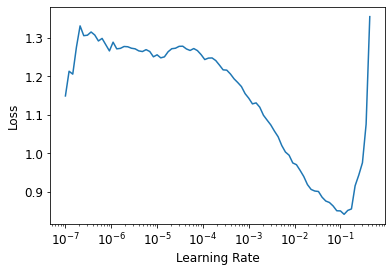

In [44]:
learn = cnn_learner(dls, resnet18, metrics = accuracy)
lr_min, lr_steep = learn.lr_find()

In [45]:
print(f"Minimum/10: {lr_min:.2e}, steepest_point: {lr_steep:.2e}")

Minimum/10: 1.20e-02, steepest_point: 4.37e-03


In [46]:
learn.fine_tune(10, base_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.998822,0.479907,0.828125,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.588022,0.464706,0.816406,00:07
1,0.521238,0.401000,0.832031,00:07
2,0.446916,0.300249,0.871094,00:07
3,0.377327,0.250388,0.878906,00:07
4,0.318742,0.237803,0.890625,00:07
5,0.258633,0.238386,0.890625,00:07
6,0.223450,0.211695,0.910156,00:07
7,0.192177,0.216510,0.906250,00:07
8,0.169773,0.212895,0.910156,00:07
9,0.148242,0.208423,0.914062,00:07


### Unfreezing and Transfer Learning

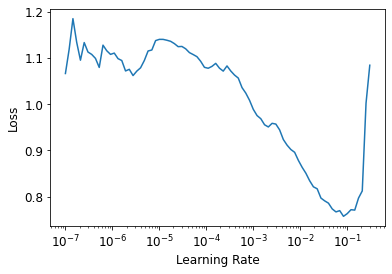

In [80]:
learn = cnn_learner(dls, resnet34, metrics = accuracy).to_fp16()
lr_min, lr_steep = learn.lr_find()

In [81]:
learn.fit_one_cycle(4, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.888070,0.598500,0.890625,00:08
1,0.590202,0.421948,0.886719,00:08
2,0.415174,0.204375,0.921875,00:08
3,0.308736,0.180213,0.925781,00:08


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=9.12010818865383e-07)

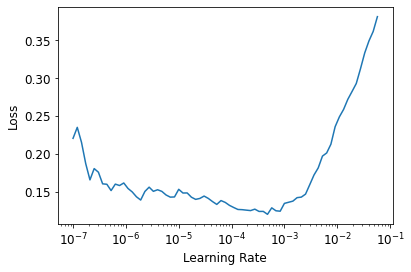

In [82]:
learn.unfreeze()
learn.lr_find()

In [83]:
learn.fit_one_cycle(10, lr_max = slice(1e-5, 7e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.115941,0.166513,0.921875,00:10
1,0.106235,0.215928,0.910156,00:10
2,0.100405,0.276643,0.945312,00:10
3,0.106452,0.256827,0.945312,00:10
4,0.094618,0.299909,0.933594,00:10
5,0.089446,0.198250,0.945312,00:10
6,0.072529,0.174695,0.949219,00:10
7,0.063347,0.157350,0.953125,00:10
8,0.051744,0.156568,0.960938,00:10
9,0.045439,0.153555,0.957031,00:10


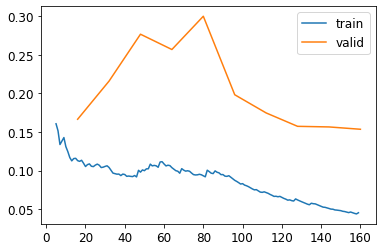

In [84]:
learn.recorder.plot_loss()

### Model Interpretation

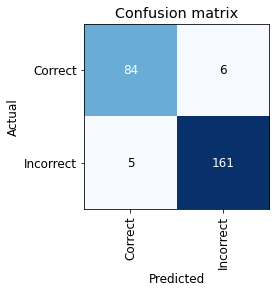

In [85]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [86]:
interp.most_confused(min_val=1)

[('Correct', 'Incorrect', 6), ('Incorrect', 'Correct', 5)]

### Creating a Notebook Model

In [87]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [88]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [89]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Saving the model for inference

In [90]:
learn.export()